In [105]:
import sys, os
# sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.integrate as si
import emcee
import corner
import getdist
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
from HzGPR import H_GPR
from HzFid import H_th
from scipy.optimize import minimize
from IPython.display import display, Math, Latex
from getdist import plots, MCSamples

# Data upload and definition

First we're going to upload the data from the DistData.csv  and from FMGas.csv and extract the relevant quantities. Both measured and calculated ones and their respective errors. 

In [151]:
dados_distancias = pd.read_csv('Saved_Data/DistData.csv', index_col=0)
#dados_distancias

In [107]:
dados_FMG = pd.read_csv('Saved_Data/FMGas.csv')
#dados_FMG

### Some needed parameters values and errors.

In [108]:
# K que é a "calibration Constant" no modelo da fração de massa do gás, e o erro =  ± 0.12
K = 0.96
sigma_K = 0.12

# \gamma é o fator de depleção dos bárions, 
gamma = 0.85
sigma_gamma = 0.085

# \Omega_{b} é o parâmetro de densidade de matéria bariônica, e o erro = ± 0.0039
omega_b = 0.0493
sigma_omega_b = 0.0039

# \Omega_{m} é o parâmetro de densidade de matéria (bariônica + CDM) e o erro = ± 0.0073
omega_m = 0.3153
sigma_omega_m = 0.0073

# \theta , e o erro =  ± 0.035
theta = 0.442
sigma_theta = 0.035

## Distances measures

First the angular diameter distances $d_{A}^{fid}$, $d_{A}^{\, obs}$ and the error associated $\sigma_{d_{A}}^{2}$

In [109]:
dA_fid = np.array(dados_distancias[' dA_fid'])
dA_obs = np.array(dados_distancias['dA_obs'])
dA_obs_erro = np.array(dados_distancias['dA_obs_erro'])

After that, the luminosity distance $d_{L}^{obs}$ and its associated error $\sigma_{d_{L}}^{2}$:

In [110]:
dL_obs = np.array(dados_distancias['dL_obs'])
dL_obs_erro = np.array(dados_distancias['dL_fid_erro'])

and finally, we use the de **CDDR** to get $d_{L}^{fid}$, that is:

$$
d_{L} = \left(1 + z\right)^{2}\cdot d_{A} \,\,\, .
$$

In [111]:
z = np.array(dados_distancias['redshift'])

In [112]:
dL_fid = np.array(dados_distancias['dL_fid'])

## $f_{gas}^{obs}$ measurements,  A(z) and $\bar{f}_{gas}$ :

For the calculation of the $\chi^{2}$ function we need both the measurements of $f_{gas}$, that is $f_{gas}^{obs}$, and the values calculated using the phenomelogical function, $\bar{f}_{gas}$ and the error associated, $\sigma_{f}^{2}$.

In [113]:
fgas_obs = np.array(dados_FMG['gmf_obs'])
fgas_erro = np.array(dados_FMG['gmf_erro'])
fgas_th = np.array(dados_FMG['gmf_bar'])
A = np.array(dados_FMG['A'])

# Função $\chi^{2}$ da Fração de Massa e Cálculo do Erro Médio do modelo 1:

Starting from the logarithm of the likelihood, we have:

$$
    \ln\,\mathcal{P} \left( y^{\text{th} }\,|\,y^{ \text{ob} },\sigma_{y^{ \text{ob} }}\right) \propto -\frac{1}{2}\chi^2 \left( y^{ \text{th} }\,|\,y^{ \text{ob} },\sigma_{y^{\text{ob} }}\right)  =
    -\frac{1}{2} \sum_n \left[
        \frac{(y^{\text{th} }(z_n)-y^{\text{ob} }_{n})^2}{\sigma_{y^{\text{ob} }_n}^2}
    \right] \,\,\, ,
$$

So, for the first two models, we will have:

$$
y^{\text{th} }(z_n) = \gamma_0(1+\eta_0z)^{2} \,\,\,\, .
$$

Thus, for this model, the $\chi^{2}$ will be:

$$
\chi^{2}=\sum_{i=1}^{40}\frac{ \left[ \gamma_{0} (1+\eta _{0}z)^{2}-
\frac{f_{\text{gas},\ i}^{\text{obs} } }{ \bar{f}_{gas} }\,\,\, \right] ^{2}}{\sigma _{\text{
tot},\ i}^{2}}\text{ .}
$$

The total error, $\sigma^{2}_{\text{tot}}$, is written as:

$$
\sigma^{2}_{\text{tot}} =  \sum_{n} \, \left[ \frac{\partial \, G(X_{n})}{\partial X_{n}}\right]\sigma^{2}_{X_{n}}
$$

Considering that $G(X_{n})= - \frac{ f^{\text{obs}}_{\text{gas}} }{ \bar{f} }$, we have:

$$ 
\sigma^{2}_{\text{tot} } = \left[ \frac{\partial}{\partial f^{ \text{obs}}_{\text{gas}} } \left( - \frac{ f^{\text{obs}}_{\text{gas}} }{ \bar{f}}\right) \right]^{2} \sigma^{2}_{f^{\text{obs}}_{\text{gas}}} + \left[ \frac{\partial}{\partial \bar{f} } \left( - \frac{ f^{\text{obs}}_{\text{gas}} }{ \bar{f}}\right) \right]^{2} \sigma^{2}_{\bar{f}}
$$

And thus,

$$ 
 \sigma^{2}_{\text{tot} } = \frac{1}{\bar{f}^{2} } \sigma^{2}_{f^{\text{obs}} } + \frac{f^{ \text{obs}^{2} } }{\bar{f}^{4} }\sigma^{2}_{\bar{f}}
$$

$$ 
 \sigma^{2}_{\text{tot} } =  \frac{f^{ \text{obs}^{2} } }{\bar{f}^{2} } \left( \frac{ \sigma^{2}_{f^{\text{obs}} }  }{{f}^{\text{obs}^{2}} }  +  \frac{ \sigma^{2}_{\bar{f}}  }{\bar{f}^{2} } \right)
$$

Finally, $ \sigma^{2}_{\bar{f}}$ is given in the same way:

$$ 
\sigma^{2}_{\bar{f}} =  \sum_{m} \, \left[ \frac{\partial \, H(X_{m})}{\partial X_{m}}\right]\sigma^{2}_{X_{n}}
$$

And thus,

$$ 
\sigma^{2}_{\bar{f}} = \left[ \frac{\partial }{\partial K  } \bar{f} \right]^{2} \sigma^{2}_{K} +  \left[ \frac{\partial }{\partial A  } \bar{f} \right]^{2} \sigma^{2}_{A} +  \left[ \frac{\partial }{\partial \Omega_{b}   } \bar{f} \right]^{2} \sigma^{2}_{\Omega_{b}} +  \left[ \frac{\partial }{\partial \Omega_{m}  } \bar{f} \right]^{2} \sigma^{2}_{\Omega_{m}} +  \left[ \frac{\partial }{\partial D^{*}_{A}  } \bar{f} \right]^{2} \sigma^{2}_{D^{*}_{A} } +  \left[ \frac{\partial }{\partial D_{A}   } \bar{f} \right]^{2} \sigma^{2}_{D_{A} } 
$$

Therefore, the error with respect to $\bar{f}$,

$$
\frac{\sigma^{2}_{ \bar{f} } }{\bar{f}^{2} } = \left[ \frac{ \sigma^{2}_{ K } }{ K^{2} } \, + \, \frac{ \sigma^{2}_{A} }{A^{2}} \, + \,  \frac{\sigma_{\gamma}^{2}}{\gamma^{2} }\, + \frac{ \sigma^{2}_{ \Omega_{b} } }{\Omega_{b}^{2}} \, + \, \sigma^{2}_{\Omega_{m}}\cdot \Omega_{m}^{2} \, + \, \left(\frac{2}{3}\right)^{2} \frac{\sigma^{2}_{D_{A} } }{D_{A}^{2} } \,    \right ]
$$

Taking care to remember that,

$$
 \sigma^{2}_{A}  =  \left( \frac{\partial A}{ \partial \theta } \right)^{2} \sigma^{2}_{\theta} 
$$

that is,

$$
\sigma^{2}_{A} = \left( \mbox{log}\, A\right)^{2} \sigma^{2}_{\theta}
$$

It can be concluded that the final expression for the total error in the first model is:

$$
\sigma^{2}_{\text{tot} } = \frac{f^{ \text{obs}^{2} } }{\bar{f}^{2} } \left[ \frac{ \sigma^{2}_{f^{\text{obs}} }  }{{f}^{\text{obs}^{2}} } \, + \, \frac{ \sigma^{2}_{ K } }{ K^{2} } \, + \, \frac{\sigma_{\gamma}^{2}}{\gamma^{2} }\, + \, \frac{\left( \mbox{log}\, A\right)^{2} \sigma^{2}_{\theta}}{A^{2}} \, + \,  \frac{ \sigma^{2}_{ \Omega_{b} } }{\Omega_{b}^{2}} \, + \, \sigma^{2}_{\Omega_{m}}\cdot \Omega_{m}^{2} \, + \, \left(\frac{2}{3}\right)^{2} \frac{\sigma^{2}_{D_{A} } }{D_{A}^{2} } \,    \right ]
$$

### Priors for the Model 1:

The priors on $\eta$ for the first model will be chosen as flat (uniform) priors. Despite being non-informative a priori, they have the advantage of not making any assumptions about the parameter except for the range of values.

$$
\ln \, \left[\,\mathcal{P}(\eta_{0})\,\right] = \left \{\begin{array}{ll}
        0 \,, & \mbox{ if }\, -5 < \eta_{0}\,  < 5. \\
        -\infty \,, & \mbox{ outro }
    \end{array}
    \right .
$$

where, 

$$
-2\ln\mathcal{P} =   \sum_{i=1}^{40}\frac{ \left[ (1+\eta _{0}z)^{2}-
\frac{f_{\text{gas},\ i}^{\text{obs} } }{ \bar{f}_{gas} }\,\,\,\,\, \right] ^{2}}{\sigma _{\text{
tot},\ i}^{2}}\,\, +\,\, \sum_{i=1}^{40}\ln 2\pi{\sigma_{\text{tot}, i}^2} 
$$

So we define the log_prior_mod1 function as follows:

In [114]:
def LogPrior_mod1(gamma_0, eta_0):
    '''
    log likelihood para uma prior não informativa, flat nos parâmetros.
    '''
    
    if  -5 < gamma_0 < 5 and -5 < eta_0 < 5:
        return 0.0

    return -np.inf

and the $\chi^{2}$ 

In [115]:
def chi2_fgas_mod1(gamma_0, eta_0, dA_fid, dA_obs, A, omega_m, omega_b):
    '''
    chi2_F_gas é a função que calcula o chi-quadrado da fração de massa do gás em
    função dos parâmetros de interesse, gamma_0 e eta_0.
    '''
    # razão f^{obs} por \bar{f}
    frac_fgas = fgas_obs/fgas_th
    
    # \sigma^{2}_tot
    sigma_tot_2 = (frac_fgas**2)*(  (fgas_erro/fgas_obs)**2.0 +  (sigma_K/K)**2.0  + (sigma_gamma/gamma)**2.0
                                                                +(sigma_omega_b/omega_b)**2.0 +   (sigma_omega_m*omega_m)**2.0
                                                                + (sigma_theta*np.log(A)/A)**2.0 + ( (2/3)*(dL_obs_erro/dL_obs) )**2    )

    
    return   (  ( gamma_0*(1+eta_0*z)**2 - frac_fgas  )**2.0 ) / sigma_tot_2 + np.log(2*np.pi*sigma_tot_2)       

We wish to minimize $\chi^{2}$ via Maximum Likelihood Estimation or **MLE** for short to get the points where we are going to start our walker, in a Monte Carlo-Markov Chain sampling of parameters distribution.

So for the MLE we need to define the log of likelihood function

In [116]:
def LogLikelihood_mod1(vals, dA_fid, dA_Obs, A, omega_m, omega_b):
    
    gamma_0, eta_0 = vals
    
    soma = sum(chi2_fgas_mod1(gamma_0, eta_0, dA_fid, dA_Obs, A, omega_m, omega_b))
    
    return -0.5*soma

# MLE for the parameters

Now we code to perform a maximum likelihood estimation, using the scipy.optimize.minimize function to find the values of the parameters gamma_0 and eta_0 that minimize the negative log-likelihood of our first model.

To achieve the desired results, we call minimize function passing loglikelihood_fgas1 function, and initial guesses (in_vals) of the values, and include the rest of arguments (args) dA_fid, dA_obs, and A as args .

In [117]:
loglikelihood = lambda *args: -LogLikelihood_mod1(*args)

in_vals = np.array([0.55, 0.5]) + 0.1 * np.random.randn(2)

resultado = minimize(loglikelihood, in_vals, args=(dA_fid, dA_obs, A, omega_m, omega_b))

best_gamma_0, best_eta_0 = resultado.x

print("Maximum likelihood estimates:")
print(f"$\gamma_0$ = ", best_gamma_0)
print(f"$\eta_0$ = ", best_eta_0)

MLE_results = [round(best_gamma_0, 3), round(best_eta_0,3)]

Maximum likelihood estimates:
$\gamma_0$ =  0.8086122434638886
$\eta_0$ =  -0.01925481764333374


# MCMC

Now we are ready to generate samples for the parameters and we're going to do this using emcee.py library and the MLE results as our initial step in the chain.

First we define the total log probability function:

In [118]:
def LogProb_mod1(params):
    
    gamma_0, eta_0 = params

    # Flat priors
    LogPrior = LogPrior_mod1(gamma_0, eta_0)
    if not np.isfinite(LogPrior):
        return -np.inf
    
    LogProb_tot = LogPrior + LogLikelihood_mod1(params, dA_fid, dA_obs, A, omega_m, omega_b)
    
    return LogProb_tot

In [119]:
totalsteps = 15500

param_ini = MLE_results
dim = len(param_ini)

posDist = param_ini + 1e-3 * np.random.randn(32,dim)
n_walkers, n_dim = posDist.shape

sampler_mod1 = emcee.EnsembleSampler(n_walkers, n_dim, LogProb_mod1)

sampler_mod1.run_mcmc(posDist, totalsteps, progress=True);

100%|███████████████████████████████| 15500/15500 [00:16<00:00, 915.21it/s]


In [152]:
print("Mean acceptance fraction: {0:.2f}".format(np.mean(sampler_mod1.acceptance_fraction)))

Mean acceptance fraction: 0.72


## Time Series of random-walks

We create a plot of the walker's time series to observe how it traverses within the parameter space. This helps visualize when the chain becomes stationary, allowing us to determine the optimal interval to perform the burn-in of the sample generated by the algorithm.

Text(0.5, 0, 'Número de Passos')

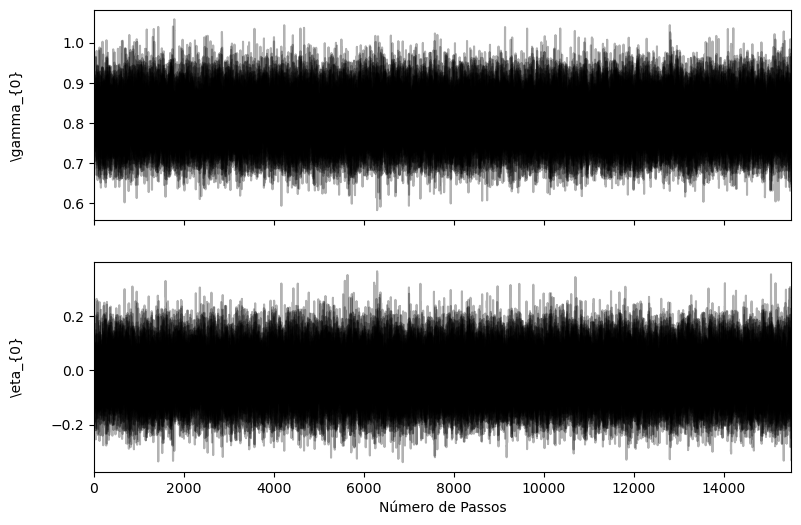

In [154]:
fig, axes = plt.subplots(n_dim, figsize=(9, 6), sharex=True)
samples_mod1 = sampler_mod1.get_chain()
labels_mod1 = [r"\gamma_{0}",r"\eta_{0}"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples_mod1[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_mod1))
    ax.set_ylabel(labels_mod1[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Número de Passos")

## Burn-In

In [155]:
# tempo de auto-correlação
tau = sampler_mod1.get_autocorr_time()
print(tau)

[32.48453496 32.42042467]


In [156]:
flat_samples_mod1 = sampler_mod1.get_chain(discard=350, thin=15, flat=True)
print("lista Anterior:",sampler_mod1.get_chain().shape)
print("Nova lista:",flat_samples_mod1.shape)

lista Anterior: (15500, 32, 2)
Nova lista: (32320, 2)


In [157]:
np.savetxt("Saved_Data/MCMC_ParamMod1_TESE.csv", flat_samples_mod1, delimiter=",")

# Resultados do Modelo 1 -  
### EEP violation parameter, $\eta$, $\eta(z) = (1+\eta_{0}z)$ and gas depletion factor $\gamma_{0}$, constant.

In [148]:
best_value = []

for i in range(n_dim):
    mcmc_mod1 = np.percentile(flat_samples_mod1[:, i], [25, 51.8, 68])
    best_value.append(mcmc_mod1[1])
    q = np.diff(mcmc_mod1)
    txt = "{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc_mod1[1], q[0], q[1], labels_mod1[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

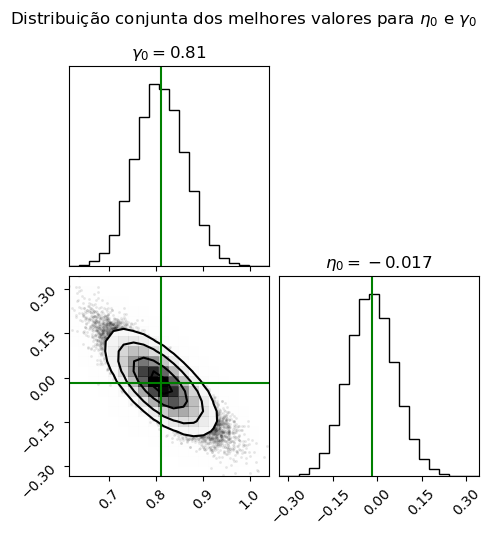

In [158]:
MCMC_flatsamples = np.vstack(flat_samples_mod1)

best_eta = best_value[1]
best_gama = best_value[0]

figure = corner.corner(MCMC_flatsamples, #truths=[best_gama, best_eta], 
                       color='black', smooth=1.25, plot_contours =True)
figure.suptitle("\n".join([r'Distribuição conjunta dos melhores valores para $\eta_{0}$ e $\gamma_{0}$']), y=1.03)
axes = np.array(figure.axes).reshape((n_dim, n_dim))
axes[0, 0].set_title(r'$\gamma_{0}= 0.81$')
axes[0, 0].axvline(x=best_gama, color='g')
axes[1, 1].set_title(r'$\eta_{0} = -0.017_{} $')
axes[1, 1].axvline(x = best_eta, color = 'g', label = 'axvline - full height')
axes[1,0].axhline(y=best_eta, c='g')
axes[1,0].axvline(x=best_gama, c='g')
